In [173]:
import os
import pandas as pd
import pathlib
import numpy as np
import torch
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
import seaborn as sns

from collections import namedtuple
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from ast import literal_eval
from torch import nn
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter

from presolve_datasets import *
from networks import *

%load_ext tensorboard
%load_ext autoreload
%autoreload 2

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Using device: {device}")

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using device: cuda


In [174]:
# writer = SummaryWriter(f'runs/cartpole-{time.strftime("%Y%m%d-%H%M%S")}')
# %reload_ext tensorboard
%tensorboard --logdir=runs

Reusing TensorBoard on port 6006 (pid 152336), started 6 days, 7:32:49 ago. (Use '!kill 152336' to kill it.)

## Define Dataset and DataLoader

In [187]:
from trajectory_utils import create_idx
from cartpole_dynamics import cartpole_dynamics_constraints

# NLP Parameters
nx, nu, N = 4, 1, 31
idx = create_idx(nx, nu, N)

Z = np.random.rand(nx*N + nu*(N-1))
# print(Z[idx.X])

xg = np.array([0, np.pi, 0, 0])

dt = 0.1
tf = 3.0

mc = 1.0
mp = 0.2
l = 0.5

# params = (Q = Q, R = R, Qf = Qf, xic = xic, xg = xg, dt = dt, N = N, idx = idx,mc = 1.0, mp = 0.2, l = 0.5)
CartpoleParams = namedtuple('CartpoleParams', ['dt', 'tf', 'N','idx', 'xg', 'mc', 'mp', 'l'])
params = CartpoleParams(dt, tf, N, idx, xg, mc, mp, l)
path = pathlib.Path(r'data\presolves\cartpole_DIRCOL_100.csv')

cartpole_warmstart = POCPSolver(path, nlp_params=params, eq_constraint_fn=cartpole_dynamics_constraints)
# cartpole_warmstart = POCPSolver(path, nlp_params=params)



# hermite_simpson(params, x1, x2, u=np.array([0]), dt=0.1)

## Train or load a model

In [188]:
cartpole_warmstart.train(epochs=50)

# path = pathlib.Path(r'C:\Users\AiPEX-WS4\Documents\AiPEX-Projects\warmstarting_NLPs\models\cartpole_model1.pth')
# cartpole_warmstart.load_model(path)

Fitting NLP data with neural network...


100%|██████████| 50/50 [15:43<00:00, 18.86s/it]


In [185]:
# cartpole_warmstart.save_model(f'models/cartpole-{time.strftime("%Y%m%d-%H%M%S")}.pth')
cartpole_warmstart.save_model(f'models/cartpole_0_0-1_reg.pth')

Model saved successfully!


## Visualize the MLP Generated Warm-Start

In [42]:
# path = pathlib.Path(r'models\cartpole-20240820-153727.pth')
# cartpole_warmstart.load_model(path)
# cartpole_warmstart.compare_trajectories(1)


len(cartpole_warmstart.t_vec)


41

(31, 2)


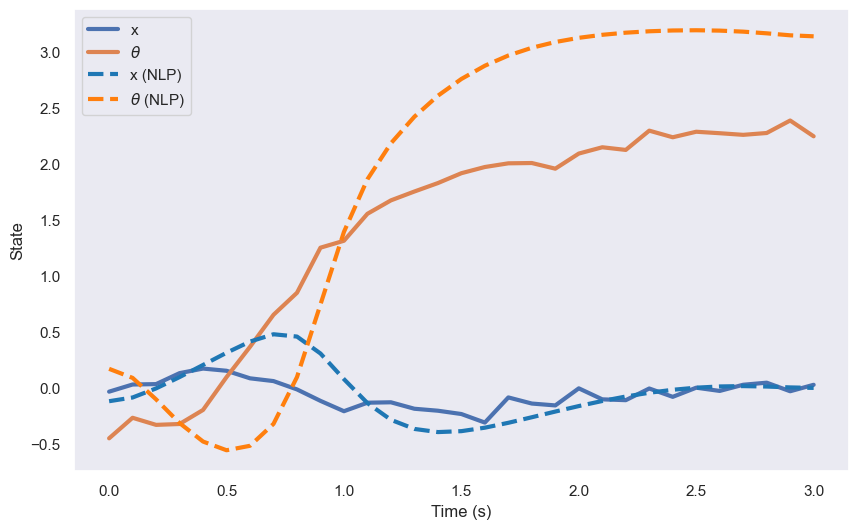

In [186]:
# path = pathlib.Path(r'models\cartpole-20240808-165541.pth')
# cartpole_warmstart.load_model(path)

cartpole_warmstart.compare_trajectories(10)


(31, 2)


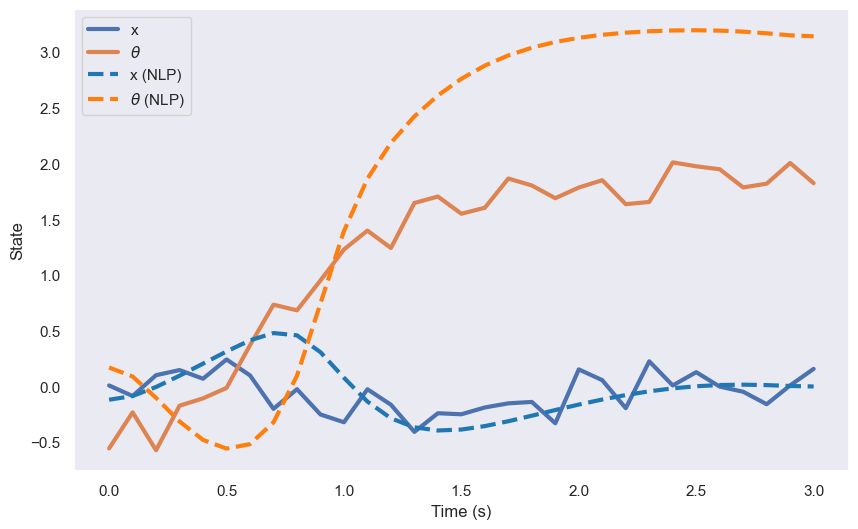

In [161]:
cartpole_warmstart.compare_trajectories(10)


## Go through the test dataset and store the MLP generated warmstart trajectories

In [38]:
cartpole_warmstart.store_warmstart_trajectories('data/warmstart_trajectories/cartpole_100_no_reg.csv')

## Visualize histograms for solve time

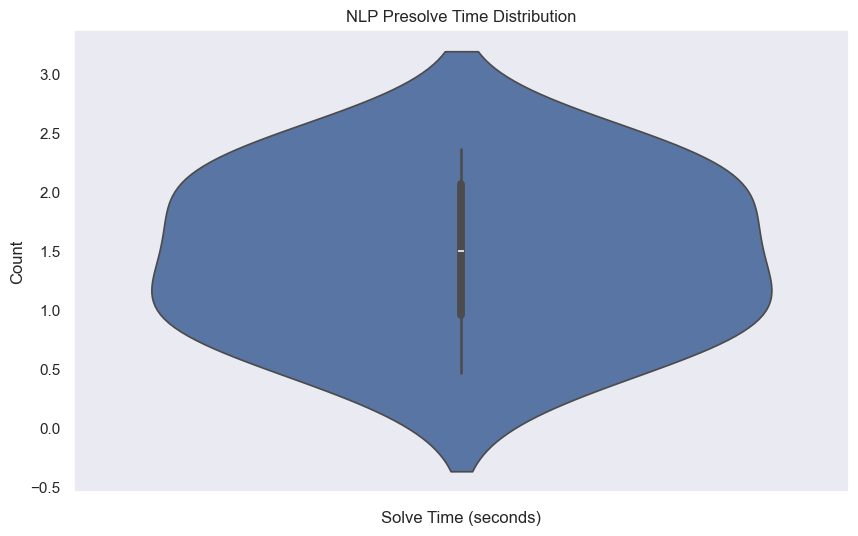

In [107]:
cartpole_warmstart.compare_solve_time()

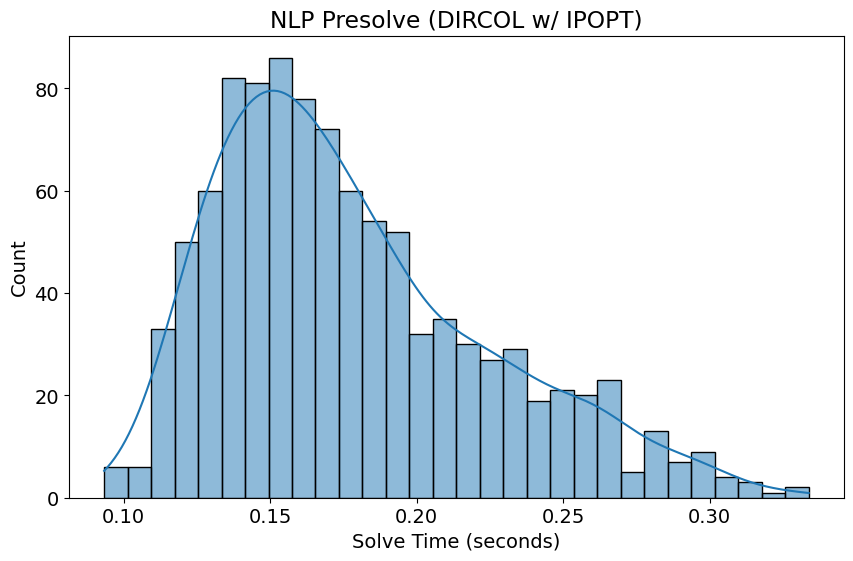

In [ ]:
# plt.figure(figsize=(10, 6))
# sns.histplot(warmstart_df['solve_time_sec']/5, bins=30, kde=True)
# plt.xlabel('Solve Time (seconds)')
# plt.ylabel('Count')
# plt.title('NLP Presolve (DIRCOL w/ IPOPT)')
# plt.show()